# Resilient Tube

In [9]:
from igraph import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

In [10]:
# Read local file and create edge list in tuple format 
df1 = pd.read_csv("Data/InputData_Edges.csv")
dfedge = df1[['From (RODS name)', 'To (RODS name)', 'Name']]
tuples = [tuple(x) for x in dfedge.values]

In [11]:
# Create graph based on edge list from previous step
ptn = Graph.TupleList(tuples, directed=True, vertex_name_attr="name", edge_attrs="line")
ptn["name"] = "PTN London Underground"
ptn.summary()

'IGRAPH DN-- 268 731 -- PTN London Underground\n+ attr: name (g), name (v), line (e)'

In [24]:
# Add attributes to nodes: NCL code, flood risk and coordinates

df2 = pd.read_csv("Data/InputData_Stations.csv")
attributes = np.asarray(df2[['Name (RODS)','NLC','FloodRisk1000a','Lat','Long']])
for station in attributes:
    try:
        vs = ptn.vs.find(name=station[0])
        vs['BetweenCent'] = ptn.betweenness(vs, directed=True)
        vs['NCL'] = station[1]
        vs['FloodRisk1000a'] = station[2]
        vs['coords'] = list(station[3:5])
    except ValueError:
        print(station[0], ' - not found!')

list(ptn.vs)

[igraph.Vertex(<igraph.Graph object at 0x108928318>, 0, {'name': 'Harrow & Wealdstone', 'NCL': 597, 'FloodRisk1000a': 0.1364, 'BetweenCent': 0.0, 'coords': [51.5925, -0.3351]}),
 igraph.Vertex(<igraph.Graph object at 0x108928318>, 1, {'name': 'Kenton', 'NCL': 620, 'FloodRisk1000a': 0.1935, 'BetweenCent': 532.0, 'coords': [51.5816, -0.3162]}),
 igraph.Vertex(<igraph.Graph object at 0x108928318>, 2, {'name': 'South Kenton', 'NCL': 709, 'FloodRisk1000a': 0.4833, 'BetweenCent': 1060.0, 'coords': [51.5701, -0.3081]}),
 igraph.Vertex(<igraph.Graph object at 0x108928318>, 3, {'name': 'North Wembley', 'NCL': 659, 'FloodRisk1000a': 0.2384, 'BetweenCent': 1584.0, 'coords': [51.5621, -0.3034]}),
 igraph.Vertex(<igraph.Graph object at 0x108928318>, 4, {'name': 'Wembley Central', 'NCL': 751, 'FloodRisk1000a': 0.0472, 'BetweenCent': 2104.0, 'coords': [51.5519, -0.2963]}),
 igraph.Vertex(<igraph.Graph object at 0x108928318>, 5, {'name': 'Stonebridge Park', 'NCL': 717, 'FloodRisk1000a': 0.2317, 'Betwe

In [25]:
# edge = ptn.es.select(_source_eq=1, _target_eq=2)

dist_matrix = cdist(attributes[:,3:5], attributes[:,3:5], 'cityblock')
dist_matrix

array([[ 0.    ,  0.2161,  0.2201, ...,  0.0654,  0.4184,  0.2096],
       [ 0.2161,  0.    ,  0.004 , ...,  0.1507,  0.2023,  0.2137],
       [ 0.2201,  0.004 ,  0.    , ...,  0.1547,  0.1983,  0.2155],
       ..., 
       [ 0.0654,  0.1507,  0.1547, ...,  0.    ,  0.353 ,  0.1442],
       [ 0.4184,  0.2023,  0.1983, ...,  0.353 ,  0.    ,  0.2306],
       [ 0.2096,  0.2137,  0.2155, ...,  0.1442,  0.2306,  0.    ]])

In [37]:
node = ptn.vs(100)
list(node)

[igraph.Vertex(<igraph.Graph object at 0x1164fc318>, 100, {'FloodRisk1000a': 0.0, 'name': "St. John's Wood", 'coords': [51.5347, -0.174], 'NCL': 696})]

In [60]:
# sel = ptn.vs.select(NCL=501)
# list(sel)

edge = ptn.es.select(_source_eq=163, _target_eq=196)
list(edge)

[]

**Create target list by floooding**

In [6]:
# Process used during dacas meeting, will be replaced by vertex probaility
df3 = pd.read_csv("Data/InputData_Stations.csv")
flood = df3[['name','FloodRisk1000a']]
threshold = flood['name'][flood.FloodRisk1000a > 0.3]
targets = []

for i in threshold:
    targets.append(i)

ptn2 = ptn
targets

['BARONS COURT',
 'BOND STREET',
 'BURNT OAK',
 'KENSINGTON (OLYMPIA)',
 'LANCASTER GATE',
 'MOOR PARK',
 'NEASDEN',
 'SOUTH KENTON',
 'THEYDON BOIS',
 'WESTBOURNE PARK']

In [7]:
# Proting function

def plot_hist(tup, target):
    sns.set(context="notebook", font_scale=1.2)
    plt.figure(facecolor="white", figsize=(9, 6), dpi=300)
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Path Length distribution station: %s' % str(target))
    plt.bar(*zip(*tup))

In [25]:
# Add flow to links
coords = np.asarray(df2[['Name (RODS)','Lat','Long']])
for station in coords:
#     print(station[1:3])
    try:
        vs = ptn.vs.find(name=station[0])
        vs['coords'] = list(station[1:3])
    except ValueError:
        print(station[0], ' - not found!')

edge = ptn.es.select(_source_in = [1])
list(edge)

[igraph.Edge(<igraph.Graph object at 0x1164fc318>, 1, {'line': 'Bakerloo  Southbound: Kenton to South Kenton'}),
 igraph.Edge(<igraph.Graph object at 0x1164fc318>, 47, {'line': 'Bakerloo  Northbound: Kenton to Harrow & Wealdstone'})]

**Delete nodes based on Flood Risk**

ValueError: no such vertex: 'BARONS COURT'

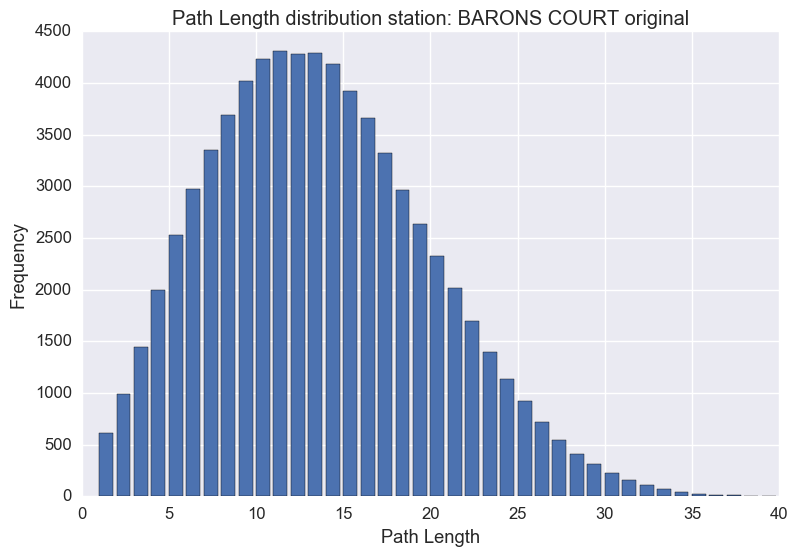

In [67]:
% matplotlib inline

for i in targets:
    path_hist_orig = list(ptn.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn.delete_vertices(ptn.vs.find(name=i))
    path_hist_dell = list(ptn.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    
    plot_hist(hist_dell, 'Damaged')

**Delete nodes based on Betweeness Centrality**

In [ ]:
% matplotlib inline

count = 0

while count <= 10:
    max_bc = max(ptn2.vs['beetw_cent'])
    target = ptn2.vs(ptn2.vs['beetw_cent'] == max_bc)['name']
    
    path_hist_orig = list(ptn2.path_length_hist(directed=True).bins())
    hist_orig = []
    for bin1 in path_hist_orig:
        x1 = bin1[0]
        y1 = bin1[2]
        hist_orig.append((x1,y1))
    plot_hist(hist_orig, i + str(' original'))

    ptn2.delete_vertices(ptn2.vs.find(name=i))
    path_hist_dell = list(ptn2.path_length_hist(directed=True).bins())
    hist_dell = []
    for bin2 in path_hist_dell:
        x2 = bin2[0]
        y2 = bin2[2]
        hist_dell.append((x2,y2))
    plot_hist(hist_dell, 'Damaged')
    
    count += 1

In [ ]:
# Ploting function
# % matplotlibe inline
# layout = ptn.layout_kamada_kawai()
# plot(ptn, layout = layout)